In this chapter, we tackle the task of news classification. The task is to classify a given news headline to one of the following categories: “Business”, “Science”, “Entertainment” and “Health”. [News Aggregator](https://archive.ics.uci.edu/dataset/359/news+aggregator) Data Set provided by Fabio Gasparetti, is the dataset we use in this chapter.


# 50. Download and Preprocess Dataset
Download [News Aggregator](https://archive.ics.uci.edu/dataset/359/news+aggregator) Data Set and create training data (train.txt), validation data (valid.txt) and test data (test.txt) as follows:

1. Unpack the downloaded zip file and read readme.txt.
2. Extract the articles such that the publisher is one of the followings: “Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com” and “Daily Mail”.
3. Randomly shuffle the extracted articles.
4. Split the extracted articles in the following ratio: the training data (80%), the validation data (10%) and the test data (10%). Then save them into files train.txt, valid.txt and test.txt, respectively. In each file, each line should contain a single instance. Each instance should contain both the name of the category and the article headline. Use Tab to separate each field.

After creating the dataset, check the number of instances contained in each category.

In [67]:
import pandas as pd
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle
import itertools

In [36]:
column_names = [
    'ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 
    'STORY', 'HOSTNAME', 'TIMESTAMP'
]
try:
    df = pd.read_csv('./newsCorpora.csv', sep='\t', header=None, names=column_names)
except FileNotFoundError:
    print("File 'newsCorpora.csv' tidak ditemukan. Pastikan file ada di folder yang sama.")
    exit()

In [37]:
publisher_to_keep = [
  'Reuters', 'Huffington Post', 'Businessweek',
  'Contactmusic.com', 'Daily Mail'
]
df_filtered = df[df['PUBLISHER'].isin(publisher_to_keep)]
df_shuffled = df_filtered.sample(frac=1, random_state=42).reset_index(drop=True)

train_df, other_df = train_test_split(df_shuffled, test_size=0.2, random_state=42, shuffle=False)
valid_df, test_df = train_test_split(other_df, test_size=0.5, random_state=42, shuffle=False)

train_df[['CATEGORY', 'TITLE']].to_csv('train.txt', sep='\t', header=False, index=False)
valid_df[['CATEGORY', 'TITLE']].to_csv('valid.txt', sep='\t', header=False, index=False)
test_df[['CATEGORY', 'TITLE']].to_csv('test.txt', sep='\t', header=False, index=False)

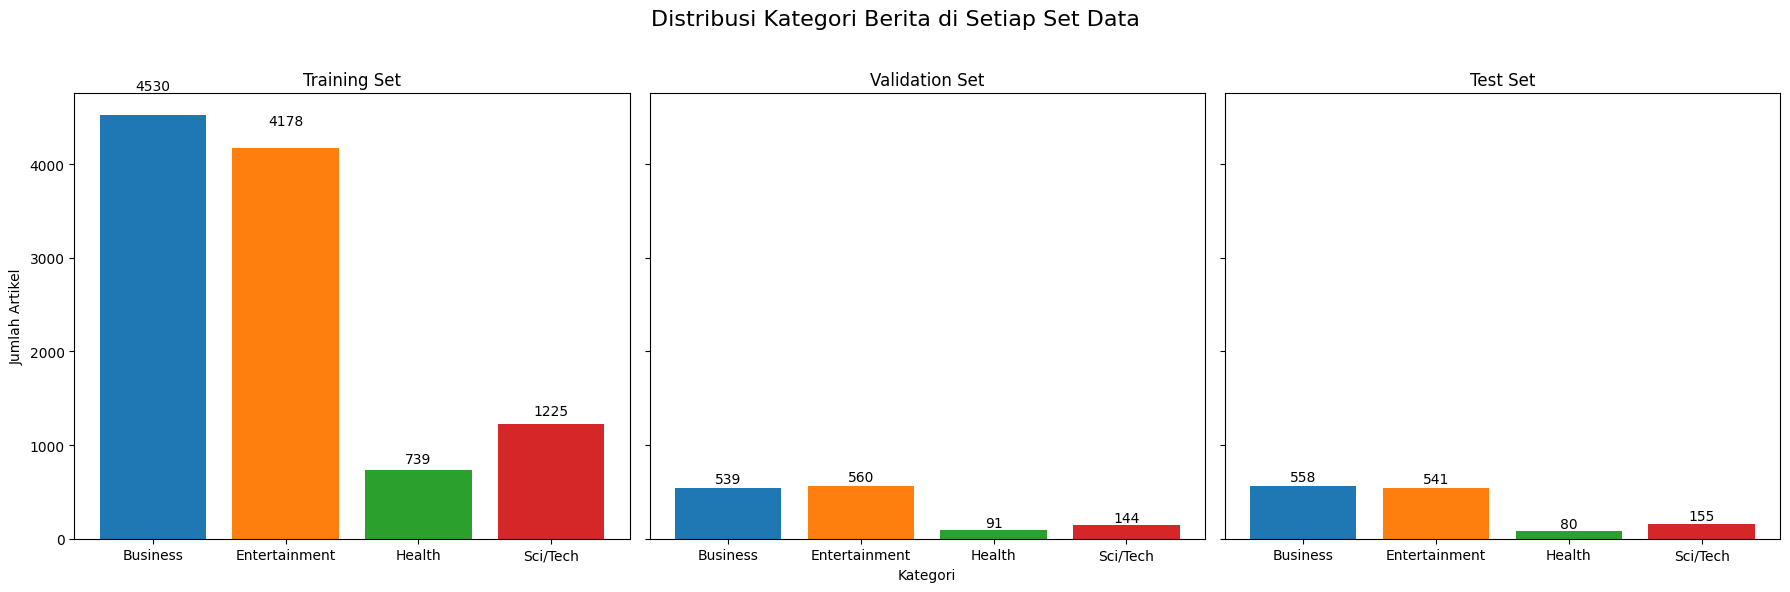

In [38]:
train_counts = train_df['CATEGORY'].value_counts().sort_index()
valid_counts = valid_df['CATEGORY'].value_counts().sort_index()
test_counts = test_df['CATEGORY'].value_counts().sort_index()

category_map = {'b': 'Business', 'e': 'Entertainment', 't': 'Sci/Tech', 'm': 'Health'}
train_counts.index = train_counts.index.map(category_map)
valid_counts.index = valid_counts.index.map(category_map)
test_counts.index = test_counts.index.map(category_map)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribusi Kategori Berita di Setiap Set Data', fontsize=16)

axes[0].bar(train_counts.index, train_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0].set_title('Training Set')
axes[0].set_ylabel('Jumlah Artikel')

axes[1].bar(valid_counts.index, valid_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Kategori')

axes[2].bar(test_counts.index, test_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[2].set_title('Test Set')

for ax in axes:
    for bar in ax.patches:
        ax.text(bar.get_x() + bar.get_width() / 2, 
                bar.get_height() + 0.05 * bar.get_height(),  
                f'{int(bar.get_height())}',  
                ha='center', 
                va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.96]) 

# 51. Feature extraction
Extract a set of features from the training, validation and test data, respectively. Save the features into files as follows: train.feature.txt, valid.feature.txt and test.feature.txt. Design the features that are useful for the news classification. The minimum baseline for the features is the tokenized sequence of the news headline.

In [39]:
def extract_features(text):
    """
    Menerima sebuah string teks (judul berita) dan mengembalikan
    urutan token yang sudah dibersihkan.
    """
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    return " ".join(tokens)


In [40]:
def process_file_for_feature_extraction(input_path, output_path):
    """
    Membaca file input, mengekstrak fitur dari setiap baris,
    dan menulis hasilnya ke file output.
    """
    data = pd.read_csv(input_path, sep='\t', header=None, names=['CATEGORY', 'TITLE'])
    data['FEATURES'] = data['TITLE'].apply(extract_features)
    output_data = data[['CATEGORY', 'FEATURES']]
    output_data.to_csv(output_path, sep='\t', header=False, index=False)
    print(f"File '{output_path}' berhasil dibuat.")

In [41]:
files_to_process = {
    'train.txt': 'train.feature.txt',
    'valid.txt': 'valid.feature.txt',
    'test.txt': 'test.feature.txt'
}

for input_file, output_file in files_to_process.items():
    try:
        process_file_for_feature_extraction(input_file, output_file)
    except FileNotFoundError:
        print(f"Peringatan: File '{input_file}' tidak ditemukan. Melewati proses untuk file ini.")


File 'train.feature.txt' berhasil dibuat.
File 'valid.feature.txt' berhasil dibuat.
File 'test.feature.txt' berhasil dibuat.


# 52. Training
Use the training data from the problem 51 and train the logistic regression model.

In [42]:
try:
    train_df = pd.read_csv('train.feature.txt', sep='\t', header=None, names=['CATEGORY', 'FEATURES'])
    print(f"Data latih berhasil dimuat. Jumlah data: {len(train_df)}")
except FileNotFoundError:
    print("File 'train.feature.txt' tidak ditemukan. Pastikan Anda sudah menjalankan Soal 51.")
    exit()

Data latih berhasil dimuat. Jumlah data: 10672


In [43]:
X_train = train_df['FEATURES']
y_train = train_df['CATEGORY']

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)

In [44]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [45]:
with open('vectorizer.pkl', 'wb') as f_vec:
    pickle.dump(vectorizer, f_vec)
print("Vectorizer telah disimpan sebagai 'vectorizer.pkl'")


Vectorizer telah disimpan sebagai 'vectorizer.pkl'


In [46]:
with open('model.pkl', 'wb') as f_model:
    pickle.dump(model, f_model)
print("Model yang telah dilatih disimpan sebagai 'model.pkl'")

Model yang telah dilatih disimpan sebagai 'model.pkl'


# 53. Prediction 
Use the logistic regression model from the problem 52. Create a program that predicts the category of a given news headline and computes the prediction probability of the model.

In [47]:
try:
    with open('model.pkl', 'rb') as f_model:
        model = pickle.load(f_model)
    with open('vectorizer.pkl', 'rb') as f_vec:
        vectorizer = pickle.load(f_vec)
    print("Model dan Vectorizer berhasil dimuat.")
except FileNotFoundError:
    print("Error: File 'model.pkl' atau 'vectorizer.pkl' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan Soal 52 untuk melatih dan menyimpan model.")
    exit()

Model dan Vectorizer berhasil dimuat.


In [48]:
def extract_features(text):
    """Membersihkan dan mentokenisasi teks input."""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    return " ".join(tokens)

In [49]:
def predict_headline(headline, visualize=False):
    """
    Menerima sebuah string judul berita, memprediksi kategori,
    dan secara opsional menampilkan grafik probabilitas.
    """
    
    cleaned_headline = extract_features(headline)
    headline_vec = vectorizer.transform([cleaned_headline])
    predicted_category_code = model.predict(headline_vec)[0]
    prediction_probabilities = model.predict_proba(headline_vec)[0]
    
    category_map = {'b': 'Business', 'e': 'Entertainment', 't': 'Sci/Tech', 'm': 'Health'}
    prob_df = pd.DataFrame({
        'Category': [category_map.get(cat, 'Unknown') for cat in model.classes_],
        'Probability': prediction_probabilities
    }).sort_values(by='Probability', ascending=False) # Urutkan dari probabilitas tertinggi
      
    if visualize:
        fig, ax = plt.subplots(figsize=(8, 4))
        
        prob_df_sorted = prob_df.sort_values(by='Probability', ascending=True)
        
        bars = ax.barh(prob_df_sorted['Category'], prob_df_sorted['Probability'], color='skyblue')
        
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{width:.2%}',
                    ha='left', va='center')

        ax.set_title(f"Probabilitas Prediksi untuk Judul:\n'{headline}'", pad=20)
        ax.set_xlabel('Probabilitas')
        ax.set_xlim(0, 1.1)  
        plt.tight_layout()
        plt.show()  
        


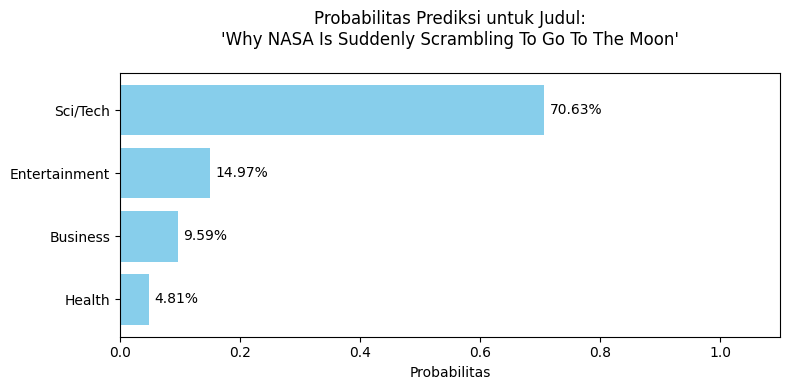

In [50]:
headline_to_test = "Why NASA Is Suddenly Scrambling To Go To The Moon"
predict_headline(headline_to_test, visualize=True)

# 54. Accuracy score 
Compute the accuracy score of the logistic regression model from the problem 52 on both the training data and the test data.

In [51]:
try:
    with open('model.pkl', 'rb') as f_model:
        model = pickle.load(f_model)
    with open('vectorizer.pkl', 'rb') as f_vec:
        vectorizer = pickle.load(f_vec)
    print("Model dan Vectorizer berhasil dimuat.")
except FileNotFoundError:
    print("Error: File 'model.pkl' atau 'vectorizer.pkl' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan Soal 52 untuk melatih dan menyimpan model.")
    exit()

Model dan Vectorizer berhasil dimuat.


In [52]:
try:
    train_df = pd.read_csv('train.feature.txt', sep='\t', header=None, names=['CATEGORY', 'FEATURES'])
    test_df = pd.read_csv('test.feature.txt', sep='\t', header=None, names=['CATEGORY', 'FEATURES'])
    print("Data latih dan data uji berhasil dimuat.")
except FileNotFoundError:
    print("Error: File 'train.feature.txt' atau 'test.feature.txt' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan Soal 51.")
    exit()

Data latih dan data uji berhasil dimuat.


In [53]:
def calculate_accuracy(df):
    """
    Menerima DataFrame, melakukan prediksi, dan menghitung skor akurasi.
    """
    X = df['FEATURES']; y_true = df['CATEGORY']
    X_vec = vectorizer.transform(X)
    y_pred = model.predict(X_vec)
    return accuracy_score(y_true, y_pred)

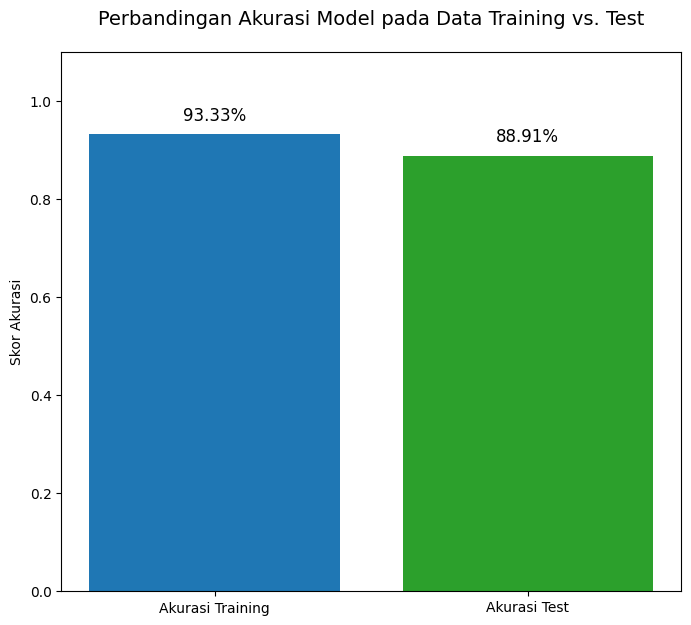

In [54]:
train_accuracy = calculate_accuracy(train_df)
test_accuracy = calculate_accuracy(test_df)

labels = ['Akurasi Training', 'Akurasi Test']
scores = [train_accuracy, test_accuracy]
colors = ['#1f77b4', '#2ca02c']
fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(labels, scores, color=colors)
ax.set_ylabel('Skor Akurasi')
ax.set_title('Perbandingan Akurasi Model pada Data Training vs. Test', fontsize=14, pad=20)
ax.set_ylim(0, 1.1) 

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2%}', 
            ha='center', va='bottom', fontsize=12)

# 55. Confusion matrix 
Create the confusion matrix of the logistic regression model from the problem 52 for both the training data and the test data.

In [55]:
X_train = train_df['FEATURES']
y_train_true = train_df['CATEGORY']
X_train_vec = vectorizer.transform(X_train)
y_train_pred = model.predict(X_train_vec)

X_test = test_df['FEATURES']
y_test_true = test_df['CATEGORY']
X_test_vec = vectorizer.transform(X_test)
y_test_pred = model.predict(X_test_vec)

In [56]:
def plot_heatmap(conf_matrix, ax, title):
    """Membuat dan menampilkan heatmap untuk confusion matrix."""
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)

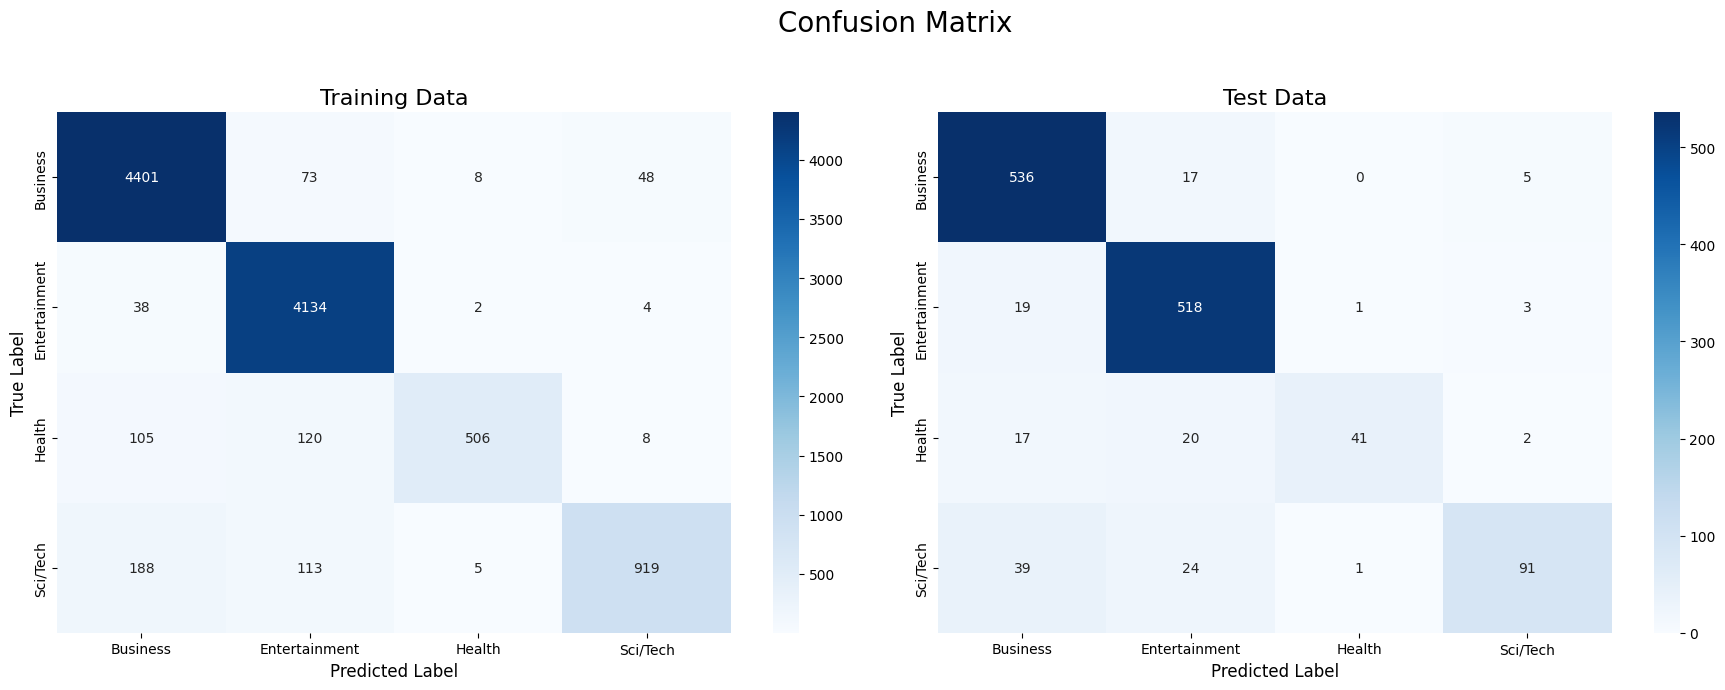

In [57]:
category_map = {'b': 'Business', 'e': 'Entertainment', 't': 'Sci/Tech', 'm': 'Health'}
labels = [category_map[cat] for cat in model.classes_]
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Confusion Matrix', fontsize=20)

cm_train = confusion_matrix(y_train_true, y_train_pred, labels=model.classes_)
plot_heatmap(cm_train, axes[0], 'Training Data')

cm_test = confusion_matrix(y_test_true, y_test_pred, labels=model.classes_)
plot_heatmap(cm_test, axes[1], 'Test Data')
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 56. Precision, recall and F1 score 
Compute the precision, recall and F1 score of the logistic regression model from the problem 52. First, compute these metrics for each category. Then summarize the score of each category using (1) micro-average and (2) macro-average.

In [59]:
print("\n--- Laporan Klasifikasi untuk Training Data ---")
report_train = classification_report(
    y_train_true, 
    y_train_pred, 
    labels=model.classes_, 
    target_names=labels,
    digits=4 ) 
print(report_train)


--- Laporan Klasifikasi untuk Training Data ---
               precision    recall  f1-score   support

     Business     0.9301    0.9715    0.9503      4530
Entertainment     0.9311    0.9895    0.9594      4178
       Health     0.9712    0.6847    0.8032       739
     Sci/Tech     0.9387    0.7502    0.8339      1225

     accuracy                         0.9333     10672
    macro avg     0.9428    0.8490    0.8867     10672
 weighted avg     0.9343    0.9333    0.9303     10672



In [60]:
print("\n--- Laporan Klasifikasi untuk Test Data ---")
report_test = classification_report(
    y_test_true, 
    y_test_pred, 
    labels=model.classes_, 
    target_names=labels,
    digits=4
)
print(report_test)


--- Laporan Klasifikasi untuk Test Data ---
               precision    recall  f1-score   support

     Business     0.8773    0.9606    0.9170       558
Entertainment     0.8946    0.9575    0.9250       541
       Health     0.9535    0.5125    0.6667        80
     Sci/Tech     0.9010    0.5871    0.7109       155

     accuracy                         0.8891      1334
    macro avg     0.9066    0.7544    0.8049      1334
 weighted avg     0.8916    0.8891    0.8813      1334



# 57. Feature weights
Use the logistic regression model from the problem 52. Check the feature weights and list the 10 most important features and 10 least important features.

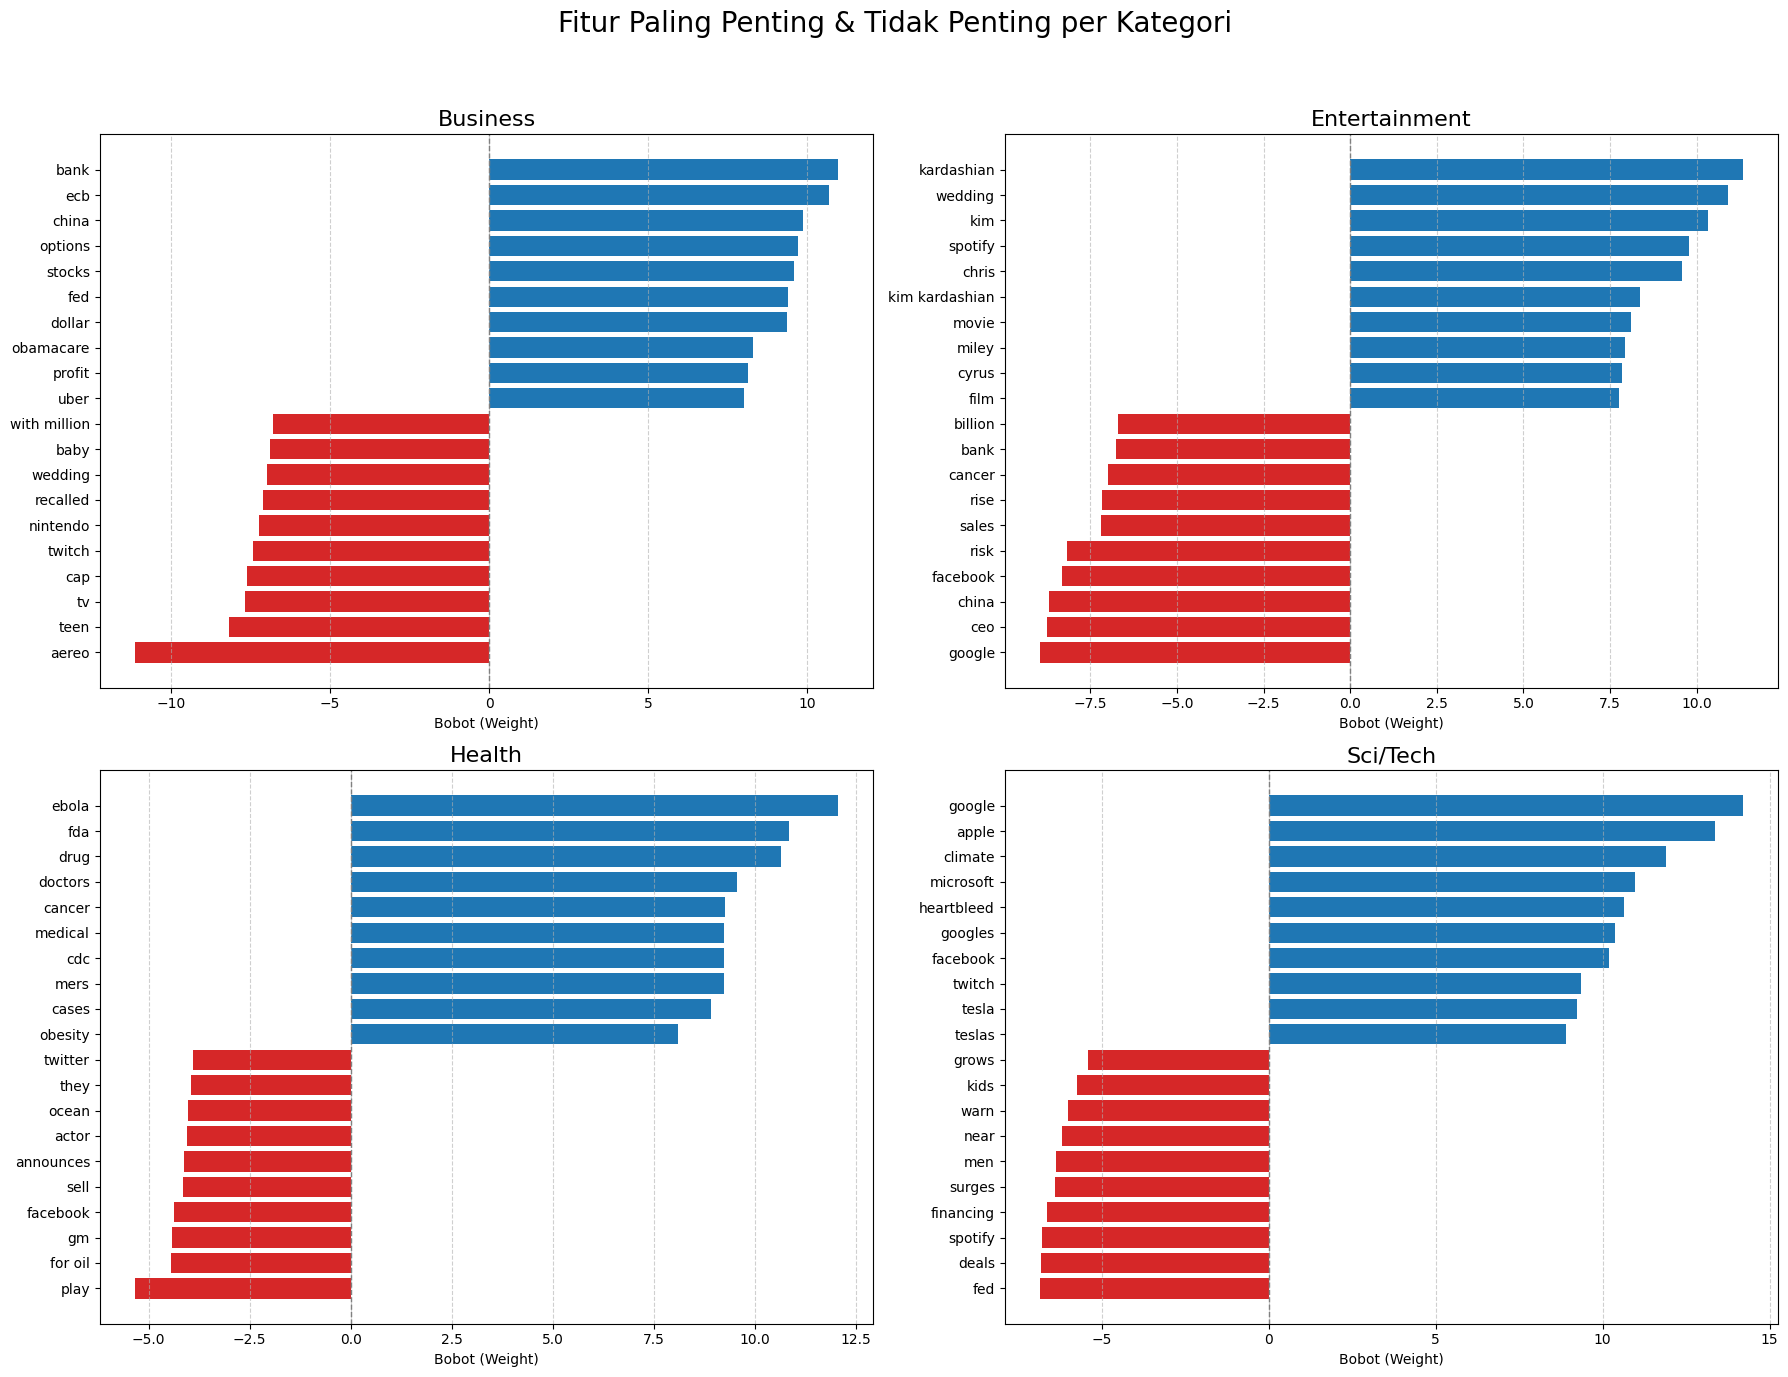

In [69]:
categories = model.classes_ 
feature_names = vectorizer.get_feature_names_out()
weights = model.coef_
category_map = {'b': 'Business', 'e': 'Entertainment', 't': 'Sci/Tech', 'm': 'Health'}

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Fitur Paling Penting & Tidak Penting per Kategori', fontsize=20)

axes = axes.flatten()

for i, category_code in enumerate(categories):
    category_name = category_map[category_code]
    ax = axes[i]  
    category_weights = weights[i]
    feature_weights = pd.DataFrame({'feature': feature_names, 'weight': category_weights})
    
    top_10 = feature_weights.sort_values(by='weight', ascending=False).head(10)
    bottom_10 = feature_weights.sort_values(by='weight', ascending=True).head(10)
    
    features_to_plot = pd.concat([top_10, bottom_10])
    features_to_plot = features_to_plot.sort_values(by='weight')
    
    colors = ['#d62728' if w < 0 else '#1f77b4' for w in features_to_plot['weight']]
    
    ax.barh(features_to_plot['feature'], features_to_plot['weight'], color=colors)
    
    ax.set_title(category_name, fontsize=16)
    ax.set_xlabel('Bobot (Weight)')
    ax.axvline(0, color='grey', lw=1, linestyle='--')
    ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()  


1. Batang Biru (ke kanan): Ini adalah kata-kata dengan bobot positif tertinggi. Semakin panjang batangnya ke kanan, semakin kuat kata tersebut menjadi penanda untuk kategori Business (contoh: "stocks", "bank").
2. Batang Merah (ke kiri): Ini adalah kata-kata dengan bobot negatif tertinggi. Semakin panjang batangnya ke kiri, semakin kuat kata tersebut menjadi penanda bahwa sebuah berita bukan termasuk kategori Business (contoh: "kardashian", "movie").

# 58. Regularization 
When training a logistic regression model, one can control the degree of overfitting by manipulating the regularization parameters. Use different regularization parameters to train the model. Then, compute the accuracy score on the training data, validation data and test data. Summarize the results on the graph, where x-axis is the regularization parameter and y-axis is the accuracy score.

In [64]:
try:
    train_df = pd.read_csv('train.feature.txt', sep='\t', header=None, names=['CATEGORY', 'FEATURES'])
    valid_df = pd.read_csv('valid.feature.txt', sep='\t', header=None, names=['CATEGORY', 'FEATURES'])
    test_df = pd.read_csv('test.feature.txt', sep='\t', header=None, names=['CATEGORY', 'FEATURES'])
    print("Semua file data fitur (train, valid, test) berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: File fitur tidak ditemukan. Pastikan Soal 51 sudah dijalankan. ({e})")
    exit()

Semua file data fitur (train, valid, test) berhasil dimuat.


In [65]:
X_train, y_train = train_df['FEATURES'], train_df['CATEGORY']
X_valid, y_valid = valid_df['FEATURES'], valid_df['CATEGORY']
X_test, y_test = test_df['FEATURES'], test_df['CATEGORY']

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)

X_valid_vec = vectorizer.transform(X_valid)
X_test_vec = vectorizer.transform(X_test)


C_values = [0.01, 0.1, 1.0, 10.0, 100.0]

train_accuracies = []
valid_accuracies = []
test_accuracies = []

for c in C_values:
    model = LogisticRegression(C=c, random_state=42, max_iter=1000)
    model.fit(X_train_vec, y_train)
    
    train_pred = model.predict(X_train_vec)
    train_acc = accuracy_score(y_train, train_pred)
    train_accuracies.append(train_acc)
    
    valid_pred = model.predict(X_valid_vec)
    valid_acc = accuracy_score(y_valid, valid_pred)
    valid_accuracies.append(valid_acc)

    test_pred = model.predict(X_test_vec)
    test_acc = accuracy_score(y_test, test_pred)
    test_accuracies.append(test_acc)
    
    print(f"  C = {c:<6} -> Train Acc: {train_acc:.4f}, Valid Acc: {valid_acc:.4f}, Test Acc: {test_acc:.4f}")




  C = 0.01   -> Train Acc: 0.7407, Valid Acc: 0.7436, Test Acc: 0.7369
  C = 0.1    -> Train Acc: 0.7922, Valid Acc: 0.7886, Test Acc: 0.7834
  C = 1.0    -> Train Acc: 0.9333, Valid Acc: 0.8808, Test Acc: 0.8891
  C = 10.0   -> Train Acc: 0.9928, Valid Acc: 0.8951, Test Acc: 0.8988
  C = 100.0  -> Train Acc: 0.9989, Valid Acc: 0.8906, Test Acc: 0.8921


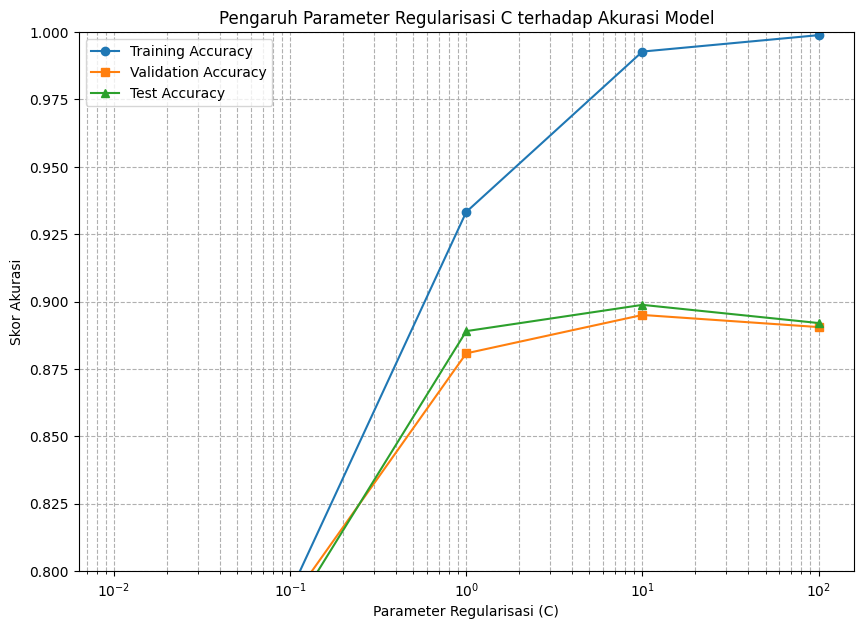

In [66]:
plt.figure(figsize=(10, 7))
plt.plot(C_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(C_values, valid_accuracies, marker='s', label='Validation Accuracy')
plt.plot(C_values, test_accuracies, marker='^', label='Test Accuracy')

plt.xscale('log')
plt.xlabel('Parameter Regularisasi (C)')
plt.ylabel('Skor Akurasi')
plt.title('Pengaruh Parameter Regularisasi C terhadap Akurasi Model')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.ylim(0.8, 1.0) # Atur limit sumbu Y agar perbedaan terlihat jelas
plt.show()


# 59. Hyper-parameter tuning
Use different training algorithms and parameters to train the model for the news classification. Search for the training algorithms and parameters that achieves the best accuracy score on the validation data. Then compute its accuracy score on the test data.

In [70]:
param_grid = {
    'ngram_range': [(1, 1), (1, 2)],
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2']
}

In [71]:
best_score = 0
best_params = {}
results = []

In [72]:
for ngram in param_grid['ngram_range']:
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=ngram)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_valid_vec = vectorizer.transform(X_valid)
    
    for penalty in param_grid['penalty']:
        for c in param_grid['C']:
            
            model = LogisticRegression(C=c, penalty=penalty, solver='liblinear', random_state=42, max_iter=1000)
            model.fit(X_train_vec, y_train)
            
            y_valid_pred = model.predict(X_valid_vec)
            score = accuracy_score(y_valid, y_valid_pred)
            
            current_params = {'ngram_range': ngram, 'C': c, 'penalty': penalty}
            results.append({'params': current_params, 'score': score})
            
            print(f"Menguji: {current_params} -> Skor Validasi: {score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = current_params

print("\nProses tuning selesai.")
print("-" * 40)
print(f"🏆 Kombinasi parameter terbaik ditemukan:")
print(best_params)
print(f"   Dengan skor akurasi pada data validasi: {best_score:.4f}")
print("-" * 40)

Menguji: {'ngram_range': (1, 1), 'C': 0.1, 'penalty': 'l1'} -> Skor Validasi: 0.7024
Menguji: {'ngram_range': (1, 1), 'C': 1.0, 'penalty': 'l1'} -> Skor Validasi: 0.8643
Menguji: {'ngram_range': (1, 1), 'C': 10.0, 'penalty': 'l1'} -> Skor Validasi: 0.8996
Menguji: {'ngram_range': (1, 1), 'C': 0.1, 'penalty': 'l2'} -> Skor Validasi: 0.7841
Menguji: {'ngram_range': (1, 1), 'C': 1.0, 'penalty': 'l2'} -> Skor Validasi: 0.8748
Menguji: {'ngram_range': (1, 1), 'C': 10.0, 'penalty': 'l2'} -> Skor Validasi: 0.9085
Menguji: {'ngram_range': (1, 2), 'C': 0.1, 'penalty': 'l1'} -> Skor Validasi: 0.6979
Menguji: {'ngram_range': (1, 2), 'C': 1.0, 'penalty': 'l1'} -> Skor Validasi: 0.8613
Menguji: {'ngram_range': (1, 2), 'C': 10.0, 'penalty': 'l1'} -> Skor Validasi: 0.8928
Menguji: {'ngram_range': (1, 2), 'C': 0.1, 'penalty': 'l2'} -> Skor Validasi: 0.7826
Menguji: {'ngram_range': (1, 2), 'C': 1.0, 'penalty': 'l2'} -> Skor Validasi: 0.8673
Menguji: {'ngram_range': (1, 2), 'C': 10.0, 'penalty': 'l2'} -

In [73]:
final_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=best_params['ngram_range'])
X_train_final_vec = final_vectorizer.fit_transform(X_train)
X_test_final_vec = final_vectorizer.transform(X_test)

final_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='liblinear',
    random_state=42,
    max_iter=1000
)
final_model.fit(X_train_final_vec, y_train)

y_test_final_pred = final_model.predict(X_test_final_vec)
final_test_score = accuracy_score(y_test, y_test_final_pred)

print("\n--- Hasil Akhir ---")
print(f"Skor akurasi model terbaik pada **Data Uji**: {final_test_score:.4f} ({final_test_score:.2%})")



--- Hasil Akhir ---
Skor akurasi model terbaik pada **Data Uji**: 0.9085 (90.85%)
